In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from imblearn.over_sampling import SMOTENC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

%matplotlib inline

# 1. Exploratory data analysis

### 1.1 Some statistics of the data

In [2]:
df = pd.read_csv('indian_food.csv', na_values=-1)
df.head()

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45.0,25.0,sweet,dessert,West Bengal,East
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80.0,30.0,sweet,dessert,Rajasthan,West
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15.0,60.0,sweet,dessert,Punjab,North
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15.0,30.0,sweet,dessert,Rajasthan,West
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15.0,40.0,sweet,dessert,West Bengal,East


In [3]:
df.shape

(255, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            255 non-null    object 
 1   ingredients     255 non-null    object 
 2   diet            255 non-null    object 
 3   prep_time       225 non-null    float64
 4   cook_time       227 non-null    float64
 5   flavor_profile  226 non-null    object 
 6   course          255 non-null    object 
 7   state           231 non-null    object 
 8   region          241 non-null    object 
dtypes: float64(2), object(7)
memory usage: 18.1+ KB


In [5]:
df.describe()

,prep_time,cook_time
count,225.000000,227.000000
mean,35.386667,38.911894
std,76.241081,49.421711
min,5.000000,2.000000
25%,10.000000,20.000000
50%,10.000000,30.000000
75%,20.000000,45.000000
max,500.000000,720.000000


The continuous features have right-skewed distribution, which we will examine further with some graphs in the next section

### 1.2 Visualizations

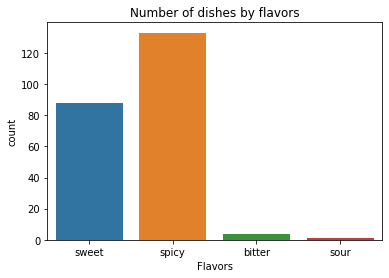

In [6]:
ax = sns.countplot(x = 'flavor_profile', data = df)
ax.set_title("Number of dishes by flavors")
ax.set_xlabel("Flavors")
plt.show()

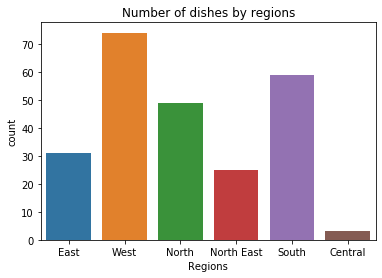

In [7]:
ax = sns.countplot(x = 'region', data = df)
ax.set_title("Number of dishes by regions")
ax.set_xlabel("Regions")
plt.show()

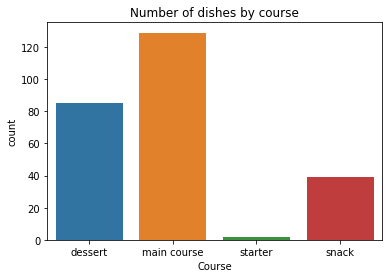

In [8]:
ax = sns.countplot(x = 'course', data = df)
ax.set_title("Number of dishes by course")
ax.set_xlabel("Course")
plt.show()

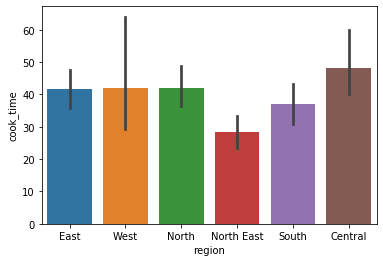

In [9]:
sns.barplot(data=df, x="region", y="cook_time")
plt.show()

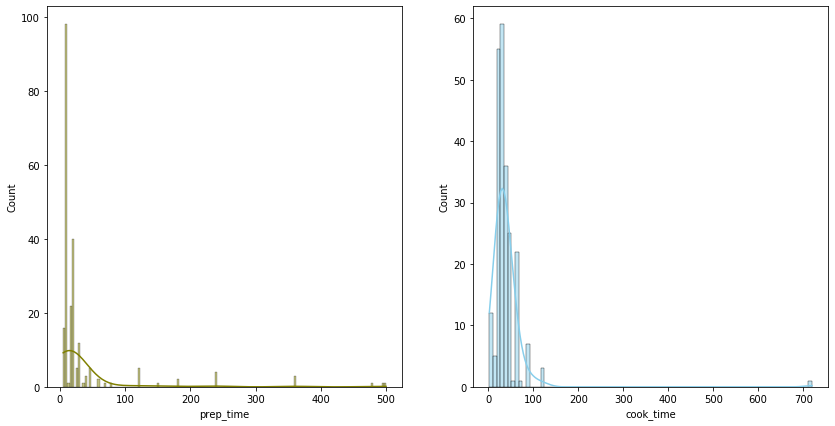

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.histplot(data = df, x = 'prep_time', kde = True, color='olive', ax =ax[0])
sns.histplot(data = df, x = 'cook_time', kde = True, color='skyblue', ax=ax[1])
plt.show()

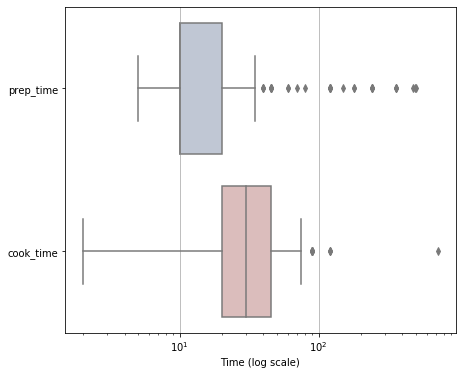

In [11]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(data = df.loc[:,['prep_time', 'cook_time']], orient='h', palette='vlag')
ax.set_xlabel("Time (log scale)")
ax.xaxis.grid(True)
plt.show()

In [12]:
def draw_boxplots(x_val, xlab):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    ax[0].set_yscale("log")
    sns.boxplot(data = df, x =x_val, y="prep_time", palette='vlag', ax=ax[0])
    sns.boxplot(data = df, x =x_val, y="cook_time", palette='vlag', ax=ax[1])
    ax[0].set_ylabel("Prep time (log scale)")
    ax[0].set_xlabel(xlab)
    ax[0].set_title("Preparation time by " + xlab)
    ax[1].set_ylabel("Cook time (log scale)")
    ax[1].set_xlabel(xlab)
    ax[1].set_title("Cooking time by "+ xlab)
    plt.show()

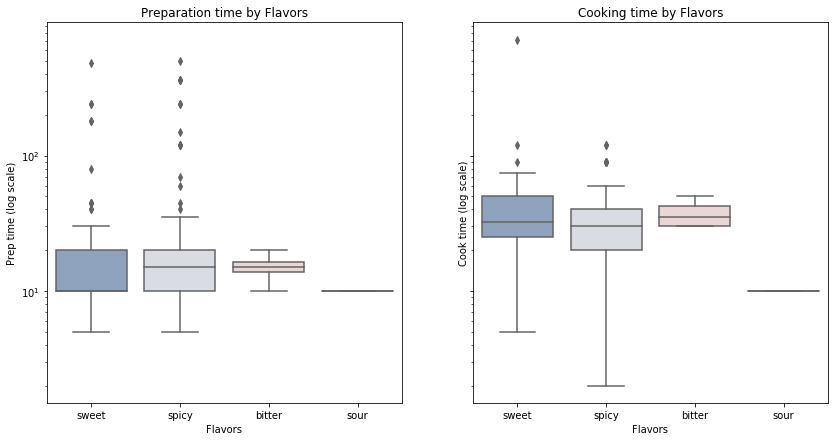

In [13]:
draw_boxplots("flavor_profile", "Flavors")

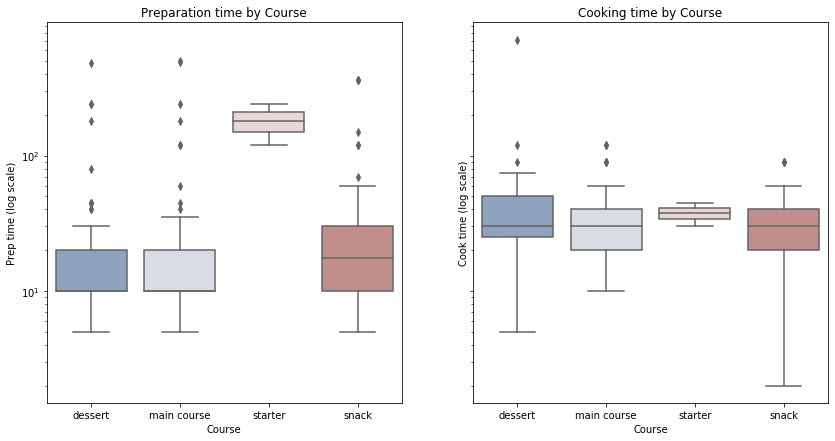

In [14]:
draw_boxplots("course", "Course")

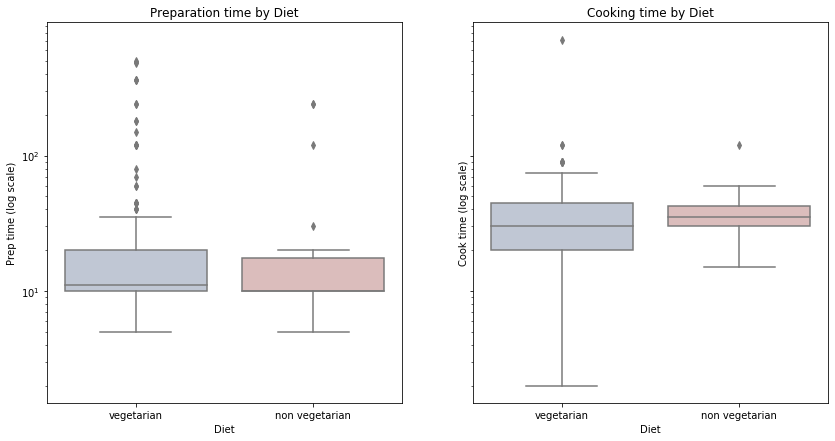

In [15]:
draw_boxplots("diet", "Diet")

In [16]:
df['diet'].value_counts()

vegetarian        226
non vegetarian     29
Name: diet, dtype: int64

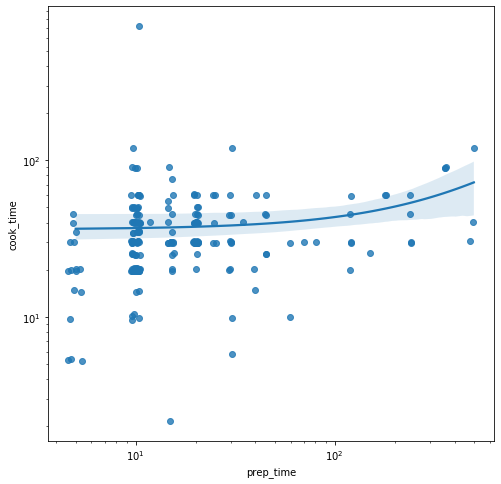

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(data=df, x='prep_time', y='cook_time', scatter=True, y_jitter=0.5, x_jitter=0.5)
plt.yscale('log')
plt.xscale('log')
plt.show()

### 1.3 Missing data

In [18]:
df.isnull().mean().round(4)*100

name               0.00
ingredients        0.00
diet               0.00
prep_time         11.76
cook_time         10.98
flavor_profile    11.37
course             0.00
state              9.41
region             5.49
dtype: float64

In [3]:
# since the data is skewed, we use mode to impute the missing data in prep_time
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_wo_state_region = df.copy()
df_wo_state_region.drop(['state', 'region'], axis=1, inplace=True)
df_wo_state_region.dropna(subset=['cook_time'], inplace=True)
df_wo_state_region['prep_time'] = imp.fit_transform(df_wo_state_region['prep_time'].values.reshape(-1, 1))
print(df_wo_state_region.isnull().mean().round(4)*100)
print(df_wo_state_region.shape)

name               0.00
ingredients        0.00
diet               0.00
prep_time          0.00
cook_time          0.00
flavor_profile    10.57
course             0.00
dtype: float64
(227, 7)


Around 10% of the data has missing flavor profile. Since our dataset is small, we will proceed to impute them. We will preprocess and encode the categorical variables before using KNN to fill in the missing flavor_profile values.

In [4]:
df_train = df_wo_state_region.copy()

In [7]:
# no duplicates
df_train.duplicated().any()

False

### 1.4 One hot encode categorical data

In [5]:
# preprocess ingredients columns
df_train['is_vegetarian'] = df_train['diet'].map({'vegetarian': 1, 'non vegetarian' : 0}).astype('object')
df_train.head()

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,is_vegetarian
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45.0,25.0,sweet,dessert,1
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80.0,30.0,sweet,dessert,1
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15.0,60.0,sweet,dessert,1
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15.0,30.0,sweet,dessert,1
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15.0,40.0,sweet,dessert,1


In [5]:
df_train = df_train.reset_index(drop=True)

In [6]:
# discretize cook_time
bins = [0, 30, 60, 720]
group_names = ['quick', 'medium', 'slow']
df_train['cook_time'] = pd.cut(df_train['cook_time'], bins, labels=group_names)

In [7]:
df_train['cook_time'].value_counts()

quick     131
medium     84
slow       12
Name: cook_time, dtype: int64

In [8]:
# feature encoding for ingredients
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df_train['ingredients'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
pd.DataFrame(denselist, columns=feature_names)

,acid,all,almond,almonds,aloo,alum,amaranth,amchur,and,anise,...,whipping,white,whole,wild,wine,yam,yellow,yoghurt,yogurt,yolks
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531785,0.000000
1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.355991,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
223,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
224,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
225,0.0,0.359378,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.459796


In [10]:
dummies = pd.DataFrame(denselist, columns=feature_names)

In [11]:
# one hot encoding the flavors
one_hot_encode_data = pd.get_dummies(df_train, columns=['flavor_profile', 'course'])

In [12]:
one_hot_encode_data = one_hot_encode_data.join(dummies.add_prefix('ingre_'))
one_hot_encode_data.drop(['ingredients', 'diet', 'name'], axis=1, inplace=True)

In [36]:
one_hot_encode_data

,prep_time,cook_time,is_vegetarian,flavor_profile_bitter,flavor_profile_sour,flavor_profile_spicy,flavor_profile_sweet,course_dessert,course_main course,course_snack,...,ingre_whipping,ingre_white,ingre_whole,ingre_wild,ingre_wine,ingre_yam,ingre_yellow,ingre_yoghurt,ingre_yogurt,ingre_yolks
0,45.0,quick,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531785,0.000000
1,80.0,quick,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,15.0,medium,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,15.0,quick,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,15.0,medium,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,15.0,medium,0,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
223,10.0,quick,1,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
224,5.0,quick,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
225,20.0,medium,1,0,0,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.459796


In [13]:
one_hot_encode_data['cook_time'] = one_hot_encode_data['cook_time'].map({'quick': 1, 'medium' : 2, 'slow':3})

In [14]:
# use KNN to impute the values for flavor profile
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
one_hot_encode_data_full = imputer.fit_transform(one_hot_encode_data)

### 1.5 Train test split

In [15]:
train_info = pd.DataFrame(one_hot_encode_data_full, columns=one_hot_encode_data.columns)
train_info.head()

,prep_time,cook_time,flavor_profile_bitter,flavor_profile_sour,flavor_profile_spicy,flavor_profile_sweet,course_dessert,course_main course,course_snack,course_starter,...,ingre_whipping,ingre_white,ingre_whole,ingre_wild,ingre_wine,ingre_yam,ingre_yellow,ingre_yoghurt,ingre_yogurt,ingre_yolks
0,45.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531785,0.0
1,80.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,15.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,15.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,15.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [16]:
# ytrain
cook_time = one_hot_encode_data['cook_time']

In [17]:
x_full = train_info.drop('cook_time', axis=1)

# 2. Baseline model

In [18]:
# healper function to evaluate a model
def evaluate_model(X, y, model):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

In [24]:
model = DummyClassifier(strategy='most_frequent')
scores = evaluate_model(x_full, cook_time, model)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.577 (0.007)


In [52]:
# base logistic regression model
base_lm = LogisticRegression()
scores = evaluate_model(x_full, cook_time, base_lm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.614 (0.048)


In [53]:
# base random forest model
base_rfc = RandomForestClassifier(random_state=0)
scores = evaluate_model(x_full, cook_time, base_rfc)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.601 (0.047)


In [55]:
base_clf = MultinomialNB()
scores = evaluate_model(x_full, cook_time, base_clf)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.576 (0.048)


In [58]:
base_svm = SVC(random_state=0)
scores = evaluate_model(x_full, cook_time, base_svm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.583 (0.019)


# 3. Feature engineering

In [19]:
# make a copy to modify
data_improve = train_info.copy()
data_improve = data_improve.reset_index(drop = True)

As we have seen before, the preparation time highly skewed to the right, with some outliers. Thus, we will bring the distribution closer to a bell-shaped normal distribution, by using box-cox transformation

In [20]:
# standardize preparation time
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method='box-cox', standardize=False)
data_improve['prep_time'] = scaler.fit_transform(data_improve['prep_time'].values.reshape(-1, 1))
data_improve

,prep_time,cook_time,flavor_profile_bitter,flavor_profile_sour,flavor_profile_spicy,flavor_profile_sweet,course_dessert,course_main course,course_snack,course_starter,...,ingre_whipping,ingre_white,ingre_whole,ingre_wild,ingre_wine,ingre_yam,ingre_yellow,ingre_yoghurt,ingre_yogurt,ingre_yolks
0,1.463390,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531785,0.000000
1,1.509367,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,1.314016,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,1.314016,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,1.314016,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,1.314016,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
223,1.227681,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
224,1.019336,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
225,1.363390,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.459796


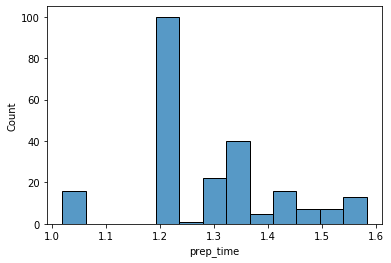

In [61]:
# the distribution post transformation
sns.histplot(data=data_improve, x='prep_time')

In [21]:
x_full2 = data_improve.drop('cook_time', axis=1)
y_full2 = data_improve['cook_time']

In [27]:
# fit the models again -- the improvement is not so significant (yet!)
lm = LogisticRegression()
scores = evaluate_model(x_full2, y_full2, lm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

rfc = RandomForestClassifier(random_state=0)
scores = evaluate_model(x_full2, y_full2, rfc)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

clf = MultinomialNB()
scores = evaluate_model(x_full2, y_full2, clf)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

svm = SVC(random_state=0)
scores = evaluate_model(x_full2, y_full2, svm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.598 (0.047)
Mean Accuracy: 0.602 (0.047)
Mean Accuracy: 0.596 (0.042)
Mean Accuracy: 0.596 (0.030)


Another problem about this dataset is that it's imbalanced. The number of slow-cooked dishes are way smaller than the other 2 categories. Thus, we are going to use a resampling method to see if fixing this problem will help improve the model as well.

In [23]:
X_resampled, y_resampled = SMOTENC(categorical_features=range(1, 11), random_state=0, 
sampling_strategy='minority').fit_resample(x_full2, y_full2)

In [24]:
X_resampled, y_resampled = SMOTENC(categorical_features=range(1, 11), random_state=0, 
sampling_strategy='minority').fit_resample(X_resampled, y_resampled)

In [25]:
lm = LogisticRegression()
scores = evaluate_model(X_resampled, y_resampled, lm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

rfc = RandomForestClassifier(random_state=0)
scores = evaluate_model(X_resampled, y_resampled, rfc)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

clf = MultinomialNB()
scores = evaluate_model(X_resampled, y_resampled, clf)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

svm = SVC(random_state=0)
scores = evaluate_model(X_resampled, y_resampled, svm)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.762 (0.036)
Mean Accuracy: 0.789 (0.035)
Mean Accuracy: 0.645 (0.044)
Mean Accuracy: 0.757 (0.052)


The accuracy scores improve across all the model, suggesting that our feature engineering techniques worked!

# 4. Feature selection

Our dataset is small (only over 200 observations), yet there are a lot of features resulting from engineering the ingredient column. Even though the model performs relatively well, having such many features implies overfitting. By using feature selection techniques to only keep a subset of significant features, we reduce the complexity of the model, hence lessen the effect of overfitting, and the model will also be less costly to be put into production. For this task, we will use 2 different feature selection methods to select the best subset of features: mutual information and chi-square, and select the technique that yields better results. Unlike chi-square, mutual information deals with datasets that have both categorical and numerical features, which is the characteristics of our dataset. However, since we only have 1 numerical feature, chi-square may still perform just as well, and we are going to examine that.


A quote I found:
*"Logistic Regression is a good model for testing feature selection methods as it can perform better if irrelevant features are removed from the model"*


!! The overall result shows that the models with feature selection do better than the previous models. Chi-square performs a little better than mutual_info but both perform comparably well overall

### 4.1 Mutual Information model

In [26]:
from functools import partial
discrete_feat_idx = range(1, 11)
score_func = partial(mutual_info_classif, discrete_features=discrete_feat_idx, random_state=0)
k_vals = list(np.arange(300, step=10))

In [27]:
import warnings
warnings.filterwarnings("ignore")
def select_features_mutual_info(X_train, Y_train, k_val):
    fs = SelectKBest(score_func=score_func, k=k_val)
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs

x_train_fs, fs = select_features_mutual_info(x_full, cook_time, 'all')

<BarContainer object of 322 artists>

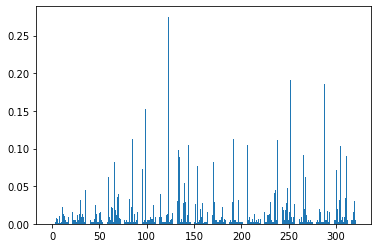

In [75]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)

Just a handful (around a fifth) of all the features have significant implications for the model, and we are to keep only these features.

#### Logistic Regression

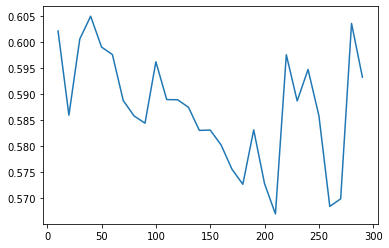

0.6049597423510468
40


In [29]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full, cook_time, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, cook_time, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
# best is k=40

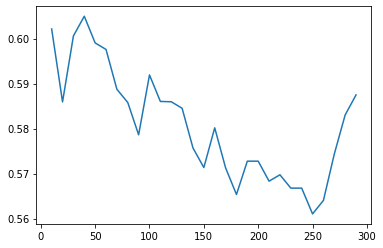

0.6049597423510468
40


In [30]:
# post-trans
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full2, y_full2, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, y_full2, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
# best k = 40

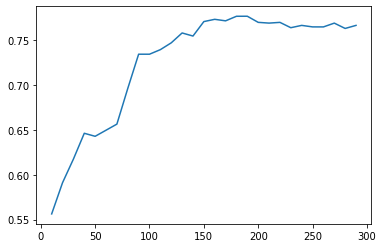

0.7769447149193986
190


In [31]:
# resampled 
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, y_resampled, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
# best k = 190

#### Random Forest

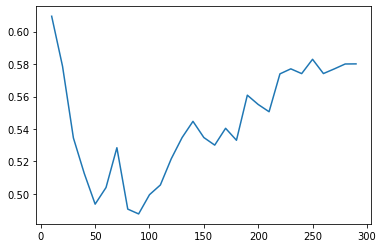

0.609500805152979
10


In [32]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full, cook_time, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, cook_time, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

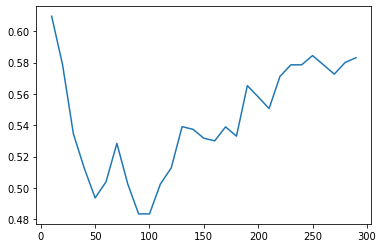

0.609500805152979
10


In [34]:
# post-trans
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full2, y_full2, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, y_full2, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

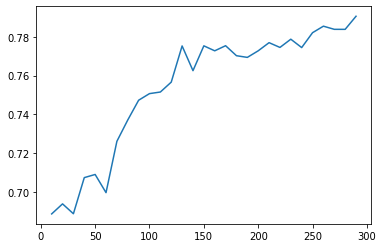

0.7905441956074869
290


In [35]:
# resampled
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, y_resampled, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
#best k = 290

#### MultiBayes

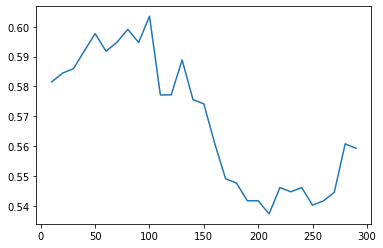

0.6035426731078904
100


In [36]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full, cook_time, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, cook_time, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
#best k = 100

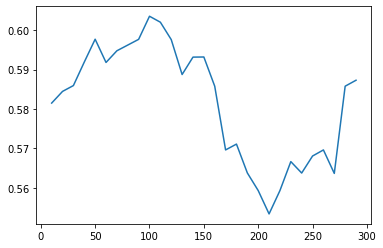

0.6035426731078904
100


In [37]:
# post-trans
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full2, y_full2, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, y_full2, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
# best k = 100

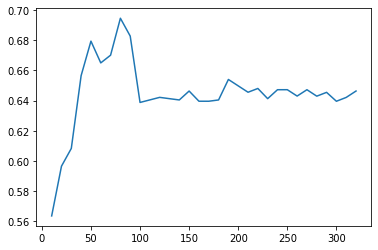

0.6946878719030618
80


In [44]:
# resampled
k_vals2 = list(np.arange(322, step=10))
acc = []
for k in k_vals2:
    x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, y_resampled, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals2, acc)
plt.show()
print(max(acc[1:]))
print(k_vals2[acc.index(max(acc[1:]))])
#best k = 80

#### SVM

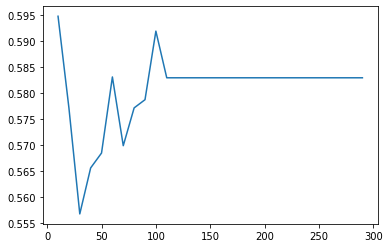

0.5947826086956521
10


In [45]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full, cook_time, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, cook_time, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
# best k = 10

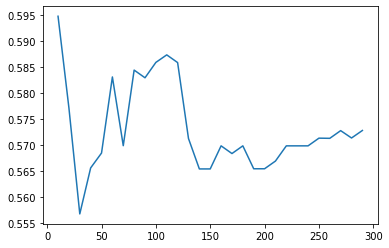

0.5947826086956521
10


In [46]:
# post-trans
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_mutual_info(x_full2, y_full2, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, y_full2, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
#best k = 10

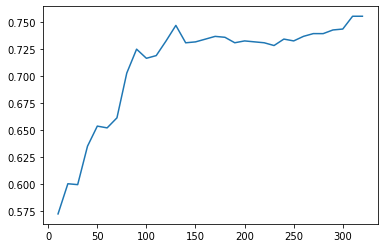

0.755782754516932
320


In [47]:
# resampled
acc = []
for k in k_vals2:
    x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, y_resampled, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals2, acc)
plt.show()
print(max(acc[1:]))
print(k_vals2[acc.index(max(acc[1:]))])
#best k = 320

Transforming the continuous variable - prep_time, help Logistic Regression converges faster, but ended up hurting the performance compared to the baseline model. The best logistic regression model obtained is with 7 features.

### 4.2 Chi-square

In [48]:
def select_features_chi2(X_train, Y_train, k_val):
    fs = SelectKBest(score_func=chi2, k=k_val)
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    # X_test_fs = fs.transform(X_test)
    return X_train_fs, fs

#### Logistic Regression

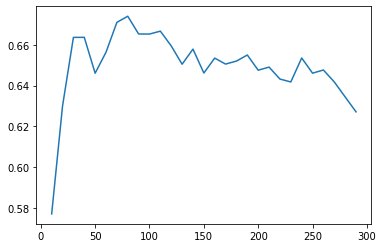

0.673977455716586
80


In [50]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full, cook_time, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, cook_time, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
# best is k=80

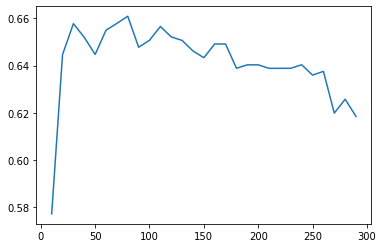

0.6609339774557165
80


In [51]:
# post-trans
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full2, y_full2, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, y_full2, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
# best k = 80

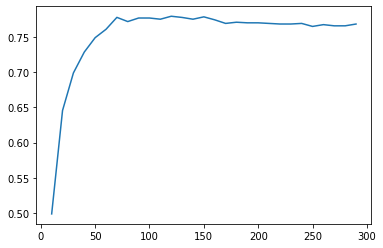

0.7794871794871797
120


In [52]:
# resampled 
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    lr_mutual_info = LogisticRegression()
    scores = evaluate_model(x_train_fs, y_resampled, lr_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
# best k = 120

#### Random Forest

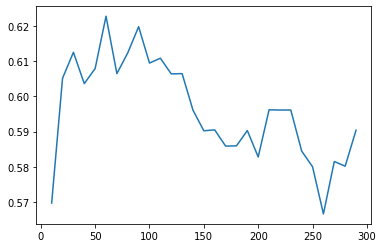

0.6227697262479871
60


In [53]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full, cook_time, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, cook_time, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
# best k = 60

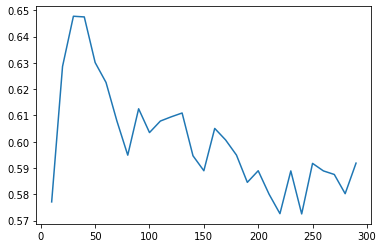

0.6477294685990337
30


In [54]:
# post-trans
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full2, y_full2, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, y_full2, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
# best k = 30

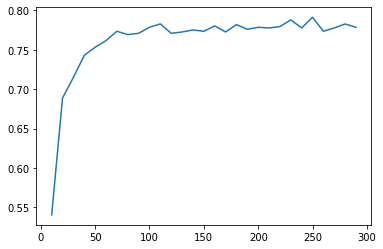

0.7914097154603484
250


In [55]:
# resampled
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    rfc_mutual_info = RandomForestClassifier(random_state=0)
    scores = evaluate_model(x_train_fs, y_resampled, rfc_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
#best k = 250

#### Multiple Bayes

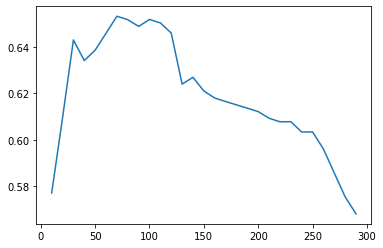

0.6532689210950079
70


In [56]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full, cook_time, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, cook_time, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
#best k = 70

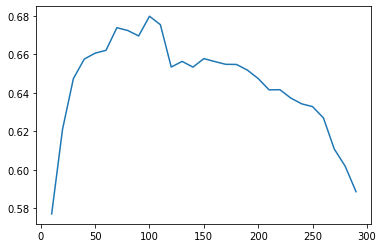

0.6798711755233493
100


In [57]:
# post-trans
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full2, y_full2, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, y_full2, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
#best k = 100

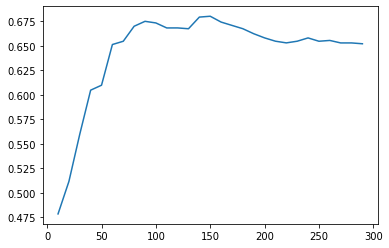

0.6803310613437197
150


In [58]:
# resampled
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    clf_mutual_info = MultinomialNB()
    scores = evaluate_model(x_train_fs, y_resampled, clf_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
#best k = 150

#### SVM

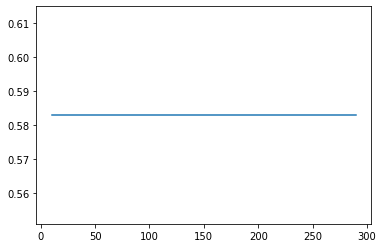

0.5829307568438004
10


In [59]:
# original
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full, cook_time, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, cook_time, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

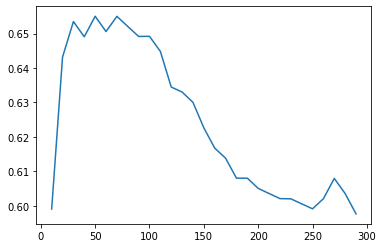

0.6550080515297906
50


In [60]:
# post-trans
acc = []
for k in k_vals:
    x_train_fs, fs = select_features_chi2(x_full2, y_full2, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, y_full2, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])
#best k = 40

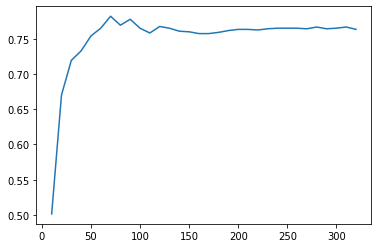

0.7820837390457646
70


In [61]:
# resampled
acc = []
for k in k_vals2:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    svm_mutual_info = SVC(random_state=0)
    scores = evaluate_model(x_train_fs, y_resampled, svm_mutual_info)
    acc.append(mean(scores))
plt.plot(k_vals2, acc)
plt.show()
print(max(acc[1:]))
print(k_vals2[acc.index(max(acc[1:]))])
#best k = 70

# 5. Model tuning

We are going to tune the best models we achieve so far. Besides, we are also trying out a stacking model out of these best models and evaluate the performances. So, from the above analysis, the models on the resampled data generally work better than the ones on the original data. And the chi-square feature selction models work better than the mutual info models and than other models as well. Therefore, also for the sake of stacking models, we are going to tune the models that yield equally good results when fitted on a dataset compared to other datasets. These models are LR, MultiBayes, and SVM models, fitted on the resampled, feature-selection dataset.

#### 1. FS_RESAMPLED_LR

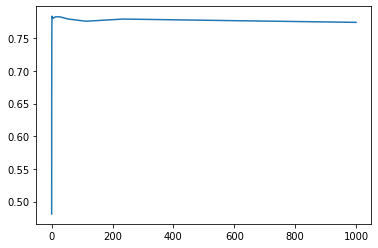

0.7837282267662017
1.438449888287663


In [65]:
# chi2 feature selection
x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=120)
acc = []
C = np.logspace(-3,3,20)
for c in C:
    lr = LogisticRegression(C=c, max_iter=500)
    # C = 1.438449888287663
    scores = evaluate_model(x_train_fs, y_resampled, lr)
    acc.append(mean(scores))

plt.plot(C, acc)
plt.show()
print(max(acc[1:]))
print(C[acc.index(max(acc[1:]))])

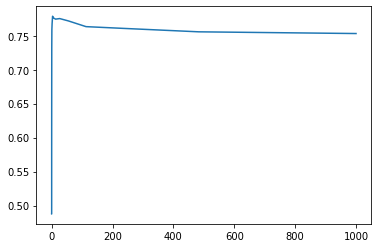

0.778578383641675
2.976351441631316


In [66]:
# mutual_info feature selection
x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=320)
acc = []
C = np.logspace(-3,3,20)
for c in C:
    lr = LogisticRegression(C=c, max_iter=500)
    # C = 2.976351441631316
    scores = evaluate_model(x_train_fs, y_resampled, lr)
    acc.append(mean(scores))

plt.plot(C, acc)
plt.show()
print(max(acc))
print(C[acc.index(max(acc))])

#### 2. FS_RESAMPLED_SVM

In [72]:
x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=70)

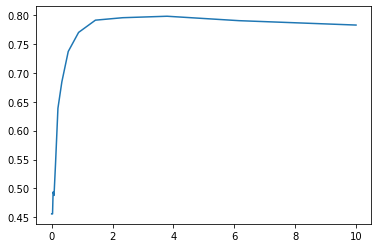

0.7981932273071515
3.792690190732246


In [73]:
acc = []
C = np.logspace(-3,1,20)
for c in C:
    svc = SVC(C=c)
    # C = 3.792690190732246
    scores = evaluate_model(x_train_fs, y_resampled, svc)
    acc.append(mean(scores))

plt.plot(C, acc)
plt.show()
print(max(acc))
print(C[acc.index(max(acc))])

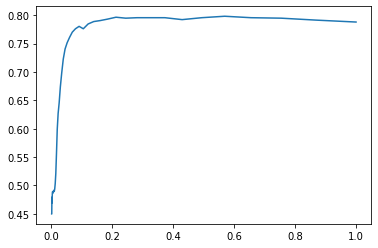

0.7982040463053122
0.5689866029018293


In [76]:
acc = []
gamma = np.logspace(-3, 0, 50)
for g in gamma:
    svc = SVC(random_state=0, C=3.792690190732246,gamma = g)
    # gamma = 0.5689866029018293
    scores = evaluate_model(x_train_fs, y_resampled, svc)
    acc.append(mean(scores))

plt.plot(gamma, acc)
plt.show()
print(max(acc))
print(gamma[acc.index(max(acc))])

In [77]:
x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=320)

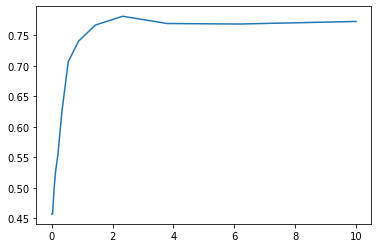

0.7812182191929029
2.3357214690901213


In [78]:
acc = []
C = np.logspace(-3,1,20)
for c in C:
    svc = SVC(C=c)
    # C = 2.3357214690901213
    scores = evaluate_model(x_train_fs, y_resampled, svc)
    acc.append(mean(scores))

plt.plot(C, acc)
plt.show()
print(max(acc))
print(C[acc.index(max(acc))])

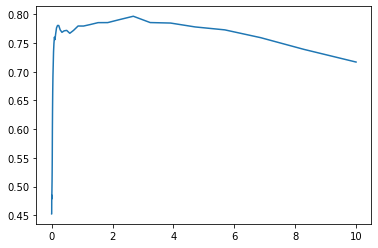

0.796473006599589
2.6826957952797246


In [80]:
acc = []
gamma = np.logspace(-3, 1, 50)
for g in gamma:
    svc = SVC(random_state=0, C=2.3357214690901213,gamma = g)
    # gamma = 2.6826957952797246
    scores = evaluate_model(x_train_fs, y_resampled, svc)
    acc.append(mean(scores))

plt.plot(gamma, acc)
plt.show()
print(max(acc))
print(gamma[acc.index(max(acc))])

#### 3. FS_RESAMPLED_MULTBAYES 

In [81]:
x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=150)

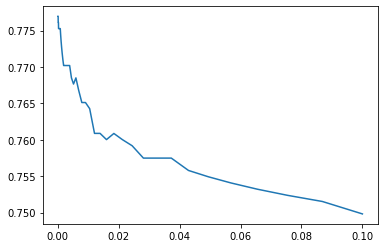

0.7769771719138808
0.0001


In [84]:
acc = []
alpha = np.logspace(-4, -1, 50)
for a in alpha:
    mulb = MultinomialNB(alpha=a)
    # alpha=0.0001
    scores = evaluate_model(x_train_fs, y_resampled, mulb)
    acc.append(mean(scores))

plt.plot(alpha, acc)
plt.show()
print(max(acc))
print(alpha[acc.index(max(acc))])

In [86]:
x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=80)

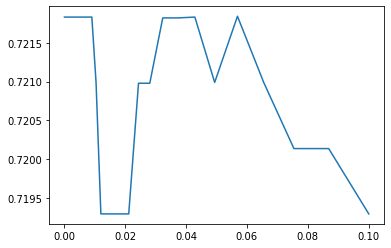

0.7218435572865952
0.05689866029018293


In [87]:
acc = []
alpha = np.logspace(-4, -1, 50)
for a in alpha:
    mulb = MultinomialNB(alpha=a)
    # alpha = 0.05689866029018293
    scores = evaluate_model(x_train_fs, y_resampled, mulb)
    acc.append(mean(scores))

plt.plot(alpha, acc)
plt.show()
print(max(acc))
print(alpha[acc.index(max(acc))])

#### 4. FS_RESAMPLED_RFC

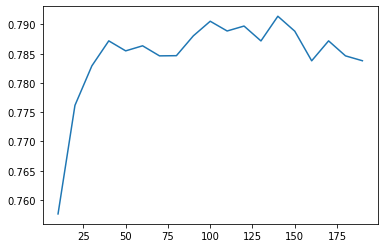

0.7913988964621878
140


In [88]:
x_train_fs, fs = select_features_mutual_info(X_resampled, y_resampled, k_val=290)
acc = []
n_est = np.arange(start=10, stop = 200, step=10)
for n in n_est:
    rf = RandomForestClassifier(n_estimators=n, random_state=0)
    # n_est=130
    scores = evaluate_model(x_train_fs, y_resampled, rf)
    acc.append(mean(scores))

plt.plot(n_est, acc)
plt.show()
print(max(acc))
print(n_est[acc.index(max(acc))])

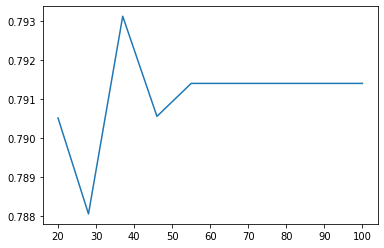

0.7931191171697501
37


In [90]:
acc = []
max_depth = [int(x) for x in np.linspace(20, 100, num = 10)]
for m in max_depth:
    rf = RandomForestClassifier(n_estimators=140, random_state=0, max_depth=m)
    # max_depth = 37
    scores = evaluate_model(x_train_fs, y_resampled, rf)
    acc.append(mean(scores))

plt.plot(max_depth, acc)
plt.show()
print(max(acc))
print(max_depth[acc.index(max(acc))])

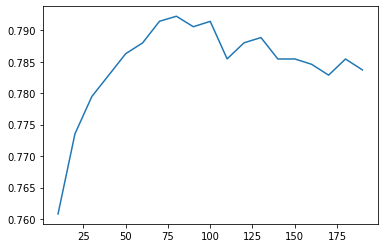

0.7922211403224062
80


In [91]:
x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=250)
acc = []
n_est = np.arange(start=10, stop = 200, step=10)
for n in n_est:
    rf = RandomForestClassifier(n_estimators=n, random_state=0)
    # n_est=80
    scores = evaluate_model(x_train_fs, y_resampled, rf)
    acc.append(mean(scores))

plt.plot(n_est, acc)
plt.show()
print(max(acc))
print(n_est[acc.index(max(acc))])

0.7939197230336472
37


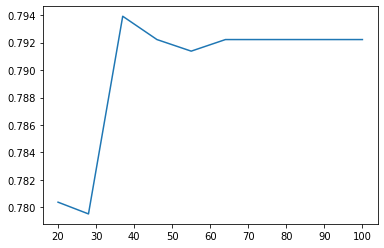

In [92]:
acc = []
max_depth = [int(x) for x in np.linspace(20, 100, num = 10)]
for m in max_depth:
    rf = RandomForestClassifier(n_estimators=80, random_state=0, max_depth=m)
    # max_depth = 37
    scores = evaluate_model(x_train_fs, y_resampled, rf)
    acc.append(mean(scores))

plt.plot(max_depth, acc)
print(max(acc))
print(max_depth[acc.index(max(acc))])

#### Stacking

Initially, I tried using pipelines inside each model in the stacking for feature selection, since each model performs well on a different chi-square selection threshold. However, splitting these thresholds up hurts the performance, and it turns out that the threshold of k for the stacking model also diverts slightly from the individual thresholds we've seen above, suggesting that for these models to work together, we need to choose a "common" threshold.

The result also shows that re-examining the best number of features selected to build the stacked model as a whole is better than letting each individual model select its own subset of features. All the stacking models show consistently good result (most of them peaks at >= 80% accuracy), with the best performing models are the stacking of all 4 models, logistic-multibayes-svm model and svm-mulbayes model. These models are going to be examined more in-depth, with other metrics like recall and f1_score to determine which one is the best model overall.

In [96]:
# models with individual feature selection threshold stacked together
models = [
    ('lr', make_pipeline(SelectKBest(score_func=chi2, k=120), LogisticRegression(C=1.438449888287663, max_iter=500) )),
    ('svm', make_pipeline(SelectKBest(score_func=chi2, k=70), SVC(random_state=0, C=3.792690190732246,gamma = 0.5689866029018293) )), 
    ('mulb', make_pipeline(SelectKBest(score_func=chi2, k=150), MultinomialNB(alpha=0.0001) )),
    ('rfc', make_pipeline(SelectKBest(score_func=chi2, k=250), RandomForestClassifier(n_estimators=80, random_state=0, max_depth=37) ))]

level1 = LogisticRegression()
stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
scores = evaluate_model(X_resampled, y_resampled, stacking)
mean(scores)

0.7744022503516175

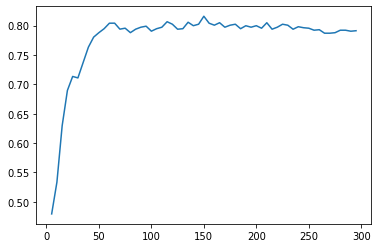

In [97]:
# models with a common feature selection threshold stacked together
models = [
    ('lr', LogisticRegression(C=1.438449888287663, max_iter=500) ),
    ('svm', SVC(random_state=0, C=3.792690190732246,gamma = 0.5689866029018293) ), 
    ('mulb', MultinomialNB(alpha=0.0001) ),
    ('rfc', RandomForestClassifier(n_estimators=80, random_state=0, max_depth=37) )]

acc = []
k_vals = np.arange(300, step=5)
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
    scores = evaluate_model(x_train_fs, y_resampled, stacking)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()

In [98]:
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

0.8159904792816186
150


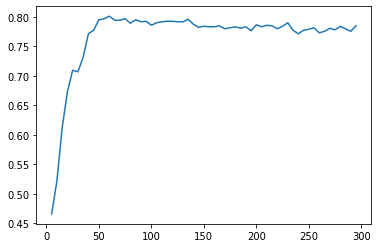

0.8007681488694147
60


In [102]:
# 3 most accurate models
models = [
    ('lr', LogisticRegression(C=1.438449888287663, max_iter=500) ),
    ('svm', SVC(random_state=0, C=3.792690190732246,gamma = 0.5689866029018293) ), 
    ('rfc', RandomForestClassifier(n_estimators=80, random_state=0, max_depth=37) ) ]

acc = []
k_vals = np.arange(300, step=5)
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
    scores = evaluate_model(x_train_fs, y_resampled, stacking)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

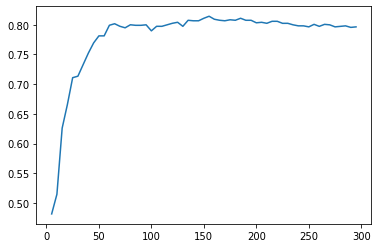

0.8142702585740563
155


In [103]:
# Other combinations
models = [
    ('lr', LogisticRegression(C=1.438449888287663, max_iter=500) ),
    ('svm', SVC(random_state=0, C=3.792690190732246,gamma = 0.5689866029018293) ), 
    ('mulb', MultinomialNB(alpha=0.0001) ) ]

acc = []
k_vals = np.arange(300, step=5)
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
    scores = evaluate_model(x_train_fs, y_resampled, stacking)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

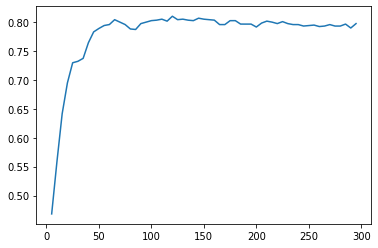

0.8100075732987126
120


In [105]:
# Other combinations
models = [
    ('rfc', RandomForestClassifier(n_estimators=80, random_state=0, max_depth=37, n_jobs=-1) ),
    ('lr', LogisticRegression(C=1.438449888287663, max_iter=500) ), 
    ('mulb', MultinomialNB(alpha=0.0001) ) ]

acc = []
k_vals = np.arange(300, step=5)
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
    scores = evaluate_model(x_train_fs, y_resampled, stacking)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

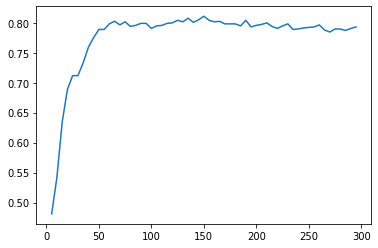

0.8108947311478959
150


In [106]:
# Other combinations
models = [
    ('rfc', RandomForestClassifier(n_estimators=80, random_state=0, max_depth=37, n_jobs=-1) ),
    ('svm', SVC(random_state=0, C=3.792690190732246,gamma = 0.5689866029018293) ), 
    ('mulb', MultinomialNB(alpha=0.0001) ) ]

acc = []
k_vals = np.arange(300, step=5)
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
    scores = evaluate_model(x_train_fs, y_resampled, stacking)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

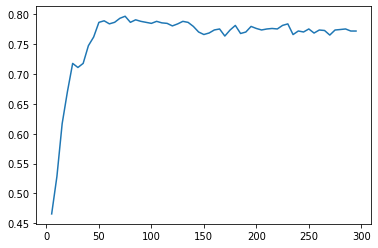

0.7965487395867143
75


In [101]:
# 2 most accurate models
models = [
    ('svm', SVC(random_state=0, C=3.792690190732246,gamma = 0.5689866029018293) ), 
    ('rfc', RandomForestClassifier(n_estimators=80, random_state=0, max_depth=37) ) ]

acc = []
k_vals = np.arange(300, step=5)
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
    scores = evaluate_model(x_train_fs, y_resampled, stacking)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

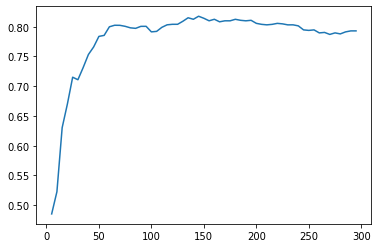

0.8176890619928596
145


In [107]:
# 
models = [
    ('svm', SVC(random_state=0, C=3.792690190732246,gamma = 0.5689866029018293) ), 
    ('mulb', MultinomialNB(alpha=0.0001) ) ]

acc = []
k_vals = np.arange(300, step=5)
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
    scores = evaluate_model(x_train_fs, y_resampled, stacking)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

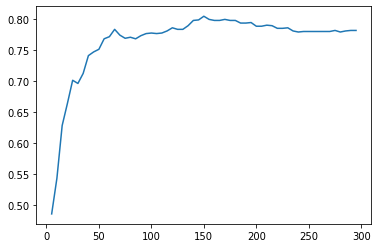

0.8040895813047713
150


In [108]:
# 
models = [
    ('lr', LogisticRegression(C=1.438449888287663, max_iter=500) ), 
    ('mulb', MultinomialNB(alpha=0.0001) ) ]

acc = []
k_vals = np.arange(300, step=5)
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
    scores = evaluate_model(x_train_fs, y_resampled, stacking)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

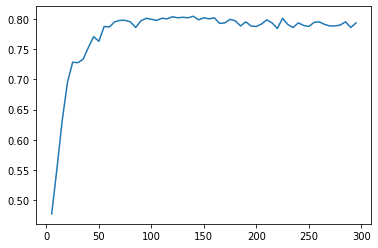

0.8049659201557938
140


In [109]:
# 
models = [
    ('rfc', RandomForestClassifier(n_estimators=80, random_state=0, max_depth=37, n_jobs=-1) ), 
    ('mulb', MultinomialNB(alpha=0.0001) ) ]

acc = []
k_vals = np.arange(300, step=5)
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
    scores = evaluate_model(x_train_fs, y_resampled, stacking)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

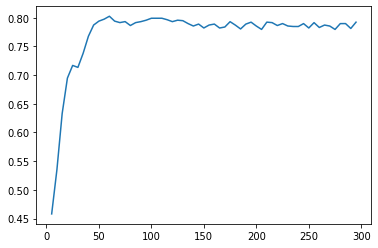

0.8024775505788164
60


In [110]:
models = [
    ('rfc', RandomForestClassifier(n_estimators=80, random_state=0, max_depth=37, n_jobs=-1) ), 
    ('lr', LogisticRegression(C=1.438449888287663, max_iter=500) ) ]

acc = []
k_vals = np.arange(300, step=5)
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
    scores = evaluate_model(x_train_fs, y_resampled, stacking)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

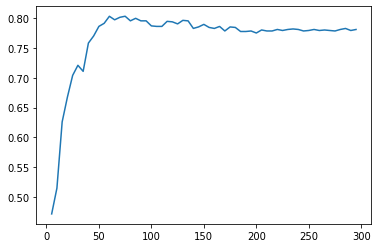

0.8033647084279997
75


In [111]:
models = [
    ('svm', SVC(random_state=0, C=3.792690190732246,gamma = 0.5689866029018293) ), 
    ('lr', LogisticRegression(C=1.438449888287663, max_iter=500) ) ]

acc = []
k_vals = np.arange(300, step=5)
for k in k_vals:
    x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=k)
    stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
    scores = evaluate_model(x_train_fs, y_resampled, stacking)
    acc.append(mean(scores))
plt.plot(k_vals, acc)
plt.show()
print(max(acc[1:]))
print(k_vals[acc.index(max(acc[1:]))])

#### Save model

In [112]:
np.savetxt('x_train.csv', X_resampled, delimiter=',')
np.savetxt('y_train.csv', y_resampled, delimiter=',')

In [116]:
# save model
import pickle
models = [
    ('svm', SVC(random_state=0, C=3.792690190732246,gamma = 0.5689866029018293) ),
    ('mulb', MultinomialNB(alpha=0.0001) )]

level1 = LogisticRegression()
stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=145)
stacking.fit(x_train_fs, y_resampled)
pickle.dump(stacking, open('finalized_svm_mulb_model.sav', 'wb'))

In [117]:
models = [
    ('lr', LogisticRegression(C=1.438449888287663, max_iter=500) ),
    ('svm', SVC(random_state=0, C=3.792690190732246,gamma = 0.5689866029018293) ), 
    ('mulb', MultinomialNB(alpha=0.0001) ),
    ('rfc', RandomForestClassifier(n_estimators=80, random_state=0, max_depth=37) )]

stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=150)
stacking.fit(x_train_fs, y_resampled)
pickle.dump(stacking, open('finalized_all_models.sav', 'wb'))

In [118]:
models = [
    ('lr', LogisticRegression(C=1.438449888287663, max_iter=500) ),
    ('svm', SVC(random_state=0, C=3.792690190732246,gamma = 0.5689866029018293) ), 
    ('mulb', MultinomialNB(alpha=0.0001) )]

stacking = StackingClassifier(estimators=models, final_estimator=level1, cv=5)
x_train_fs, fs = select_features_chi2(X_resampled, y_resampled, k_val=155)
stacking.fit(x_train_fs, y_resampled)
pickle.dump(stacking, open('finalized_lr_svm_mulb_models.sav', 'wb'))